This notebook shows some simple usage of the functions and the classes.

In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
import data, retrieve, display_tools, utils
import retrieve.learning, retrieve.tradition
from gensim import downloader

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

# Data Resources Preparation

Install some necessary resources and read the data to DataFrame

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
word2vec = downloader.load('word2vec-google-news-300')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86151\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\86151\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
data_train = pd.read_csv(r'data\train_data.tsv',sep='\t',header=0, nrows=100000)
data_val = pd.read_csv(r'data\validation_data.tsv',sep='\t',header=0, nrows=100000)
print(data_train.head())
print(data_val.head())

      qid      pid                                       query                                            passage  relevancy
0  188714  1000052  foods and supplements to lower blood sugar  Watch portion sizes: ■ Even healthy foods will...        0.0
1  995526  1000094    where is the federal penitentiary in ind  It takes THOUSANDS of Macy's associates to bri...        0.0
2  660957  1000115       what foods are good if you have gout?  The good news is that you will discover what g...        0.0
3  837202  1000252    what is the nutritional value of oatmeal  Oats make an easy, balanced breakfast. One cup...        0.0
4  130825  1000268                       definition for daring  Such a requirement would have three desirable ...        0.0
       qid      pid                                              query                                            passage  relevancy
0  1082792  1000084  what does the golgi apparatus do to the protei...  Start studying Bonding, Carbs, Proteins, Lipi

# Traditional retrieval methods

This section shows some usage of tradtional retrieval methods, including TF-IDF based model, BM 25 model, and likelihood based model with some smoothing methods.

## load data

For these traditional methods, it's better to add stop words, since these method focus on the information carried by 'key' words (of course this is not a strict rule).

In [6]:
lemmatizer = utils.Lemmatizer()
data_loader = data.DataLoader(
    stopwords = stopwords.words('english'),
    lemmatizer = lemmatizer
)

calculate inverted indices and load the data

In [ ]:
data_loader.load(data_train)

show the zipfian law

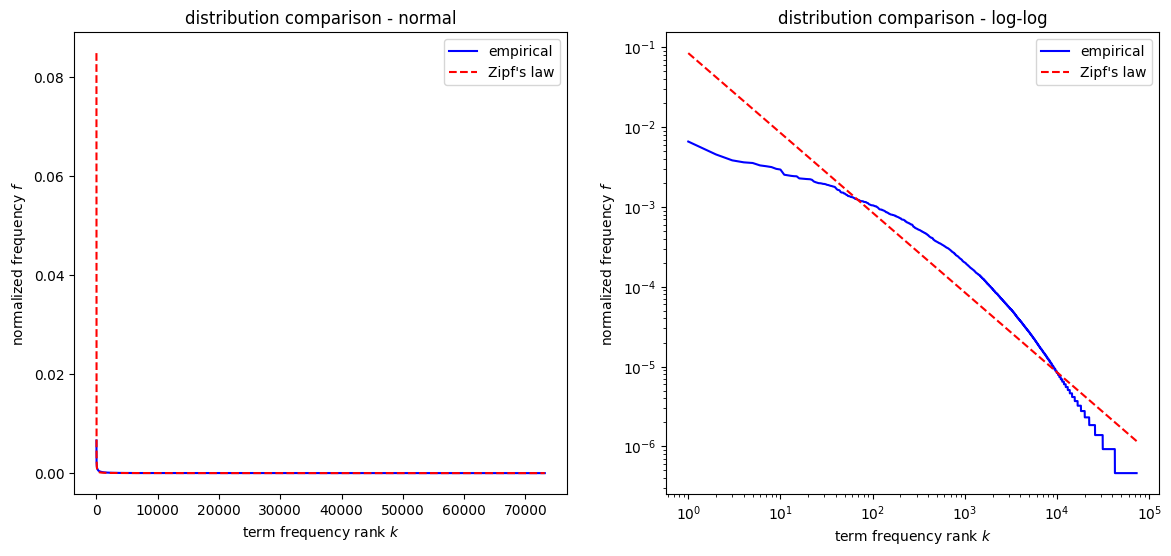

In [8]:
tf_collection = data.OneNestedDictView(data_loader.doc_loader.inverted_indices, inner_key='tf-collection')
fre_norm, zipfian = utils.calculate_normalized_frequency_zipfian(tf_collection, return_difference=False)
display_tools.visualize_frequency_zipfian(fre_norm=fre_norm, zipfian=zipfian)

## TD-IDF Retrieval Model

In [9]:
traditional_retriever = retrieve.tradition.TraditionRetriever(
    data_loader=data_loader,
    retrieve_type='tf-idf'
)

In [10]:
retrieval_results = traditional_retriever.retrieve(
    num_top_results=100
)
print(retrieval_results.head())

start : TF-IDF vector space based retrieval model
finish : TF-IDF vector space based retrieval model. Number of retrieval results is 100000.
   pid      qid     score
0    2  2102789  9.499877
1    2  1571085  8.942524
2    2  1956956  8.595127
3    2  2088281  7.958061
4    2  1591539  7.086926


## BM 25 Model

Here, a new instance of TraditionRetriever could be created. Or, reset_retrieval_method can be called to set a new method

In [11]:
traditional_retriever.reset_retrieval_method(retrieve_type='bm25')
retrieval_resultss = traditional_retriever.retrieve(
    num_top_results=100
)
print(retrieval_resultss.head())

start : BM25 retrieval model
finish : BM25 retrieval model. Number of retrieval results is 100000.
   pid      qid      score
0    2  1571085  13.242188
1    2  2088281  13.191627
2    2  1001876  12.976699
3    2  1591539  12.745006
4    2   112130  12.656749


## Likelihood Model with smoothing methods

In [12]:
traditional_retriever.reset_retrieval_method(
    retrieve_type='likelihood',
    smooth_type='lidstone'
)

retrieval_resultss = traditional_retriever.retrieve(
    num_top_results=100
)
print(retrieval_resultss.head())

start : query_liklihood retreival model with smoothing type lidstone
finish : query_liklihood retreival model with smoothing type lidstone. Number of retrieval results is 100000.
   pid      qid      score
0    2  1571085 -31.117167
1    2  1001876 -31.117904
2    2  1591539 -31.117945
3    2  2088281 -31.404685
4    2  1565597 -31.523083


Similarly, the smoothing type can be change by calling reset_retrieval_method

In [13]:
traditional_retriever.reset_retrieval_method(
    smooth_type='dirichlet'
)

retrieval_resultss = traditional_retriever.retrieve(
    num_top_results=100
)
print(retrieval_resultss.head())

start : query_liklihood retreival model with smoothing type dirichlet
finish : query_liklihood retreival model with smoothing type dirichlet. Number of retrieval results is 100000.
   pid      qid     score
0    2  1565597 -2.506350
1    2  2102789 -2.574105
2    2  1701710 -2.592425
3    2  1956956 -2.602678
4    2  2575944 -2.790901


# Learning-to-rank Models

Different from the traditonal models, which can be seen as non-parametric models, the learning-to-rank models would be trained first, and used the traind models to retreive.

## load data

Different from the traditonal models, these learning-to-rank models focus on contextual information. Therefore, these Conjunctions，Function words, tense and voice could hold important information for these models.

In [14]:
data_train_loader = data.DataLoader()
data_val_loader = data.DataLoader()

In [ ]:
data_train_loader.load(data_train)

In [ ]:
data_val_loader.load(data_val)

Below is just a simple way to integrate these vectors together - average the vectors of queries and the vectors of passages sperately, and concatenate these two vectors to a single vector.

In [17]:
data_train_features = data.extract_features(
    data_train_loader, 
    word_embedding=word2vec,
    query_candidate=data_train[['qid', 'pid', 'relevancy']]
)

In [18]:
data_val_features = data.extract_features(
    data_val_loader, 
    word_embedding=word2vec,
    query_candidate=data_val[['qid', 'pid', 'relevancy']]
)

In [19]:
print(data_train_features.head())
print(data_val_features.head())

      qid      pid  relevancy                                           features
0  188714  1000052        0.0  [-0.12841797, 0.0028948102, 0.023995535, 0.131...
1  995526  1000094        0.0  [-0.031420026, -0.07271903, 0.09767369, 0.1186...
2  660957  1000115        0.0  [-0.01550293, 0.012962341, 0.04573059, 0.17407...
3  837202  1000252        0.0  [-0.026824951, 0.014971052, 0.054530554, 0.109...
4  130825  1000268        0.0  [0.023091635, 0.047281902, 0.0423584, 0.137980...
       qid      pid  relevancy                                           features
0  1082792  1000084        0.0  [0.044048604, 0.059772197, 0.039898213, 0.0241...
1   995825  1000492        0.0  [0.011875153, 0.014404297, 0.0951004, 0.156448...
2   995825  1000494        0.0  [0.011875153, 0.014404297, 0.0951004, 0.156448...
3  1091246  1000522        0.0  [0.19881184, -0.109375, 0.15462239, 0.01712544...
4  1047854  1000585        0.0  [0.09185028, 0.039230347, 0.02709961, 0.135406...


## Logistic Regression Model

initialize the model

In [20]:
model_lr = retrieve.learning.LogisticRegression(600)

initialize the trainer

In [21]:
trainer = retrieve.learning.Trainer(
    model=model_lr,
    data=data_train_features
)

train the model

In [22]:
trainer.train(
    batch_size = 20,
    epoch = 20,
    learning_rate = 0.01)

start: train the Logistic Model
Epoch : 1, Loss : 0.0944
Epoch : 2, Loss : 0.0182
Epoch : 3, Loss : 0.0112
Epoch : 4, Loss : 0.0083
Epoch : 5, Loss : 0.0068
Epoch : 6, Loss : 0.0058
Epoch : 7, Loss : 0.0052
Epoch : 8, Loss : 0.0047
Epoch : 9, Loss : 0.0043
Epoch : 10, Loss : 0.0040
Epoch : 11, Loss : 0.0038
Epoch : 12, Loss : 0.0036
Epoch : 13, Loss : 0.0034
Epoch : 14, Loss : 0.0033
Epoch : 15, Loss : 0.0032
Epoch : 16, Loss : 0.0031
Epoch : 17, Loss : 0.0030
Epoch : 18, Loss : 0.0029
Epoch : 19, Loss : 0.0029
Epoch : 20, Loss : 0.0028
finish: train the Logistic Model


initialize the retriever

In [23]:
learning_retriever = retrieve.learning.LearningRetriever(
    model = model_lr,
    data=data_val_features
)

start retrieval

In [24]:
retrieval_results = learning_retriever.retrieve(100)
print(retrieval_results.head())

start: retrieval model
finish: retrieval model
       pid      qid  relevancy     score
0  3499316  1082792        0.0  0.002437
1  6211818  1082792        0.0  0.002054
2  6053929  1082792        0.0  0.001999
3  3664009  1082792        0.0  0.001865
4  5109024  1082792        0.0  0.001776


evaluate the retrieval results

In [25]:
retrieval_evaluation = utils.cal_metrics(results=retrieval_results)
print(f'mean ap is {retrieval_evaluation[0]}, ndcg is {retrieval_evaluation[1]}')

mean ap is 0.0009277160277501236, ndcg is 0.0154372414937991


## LambdaMART Model

In [26]:
model_lm = retrieve.learning.LambdaMART(
    max_depth=10,
    n_estimators=300
)

In [27]:
trainer.reset_model(model=model_lm)

In [28]:
trainer.train()

start: train the LambdaMART model
finish: train the LambdaMART model


In [29]:
learning_retriever.reset_model(model=model_lm)
retrieval_results = learning_retriever.retrieve(100)
print(retrieval_results.head())

start: retrieval model
finish: retrieval model
       pid      qid  relevancy     score
0   584111  1082792        0.0 -0.277490
1  2450088  1082792        0.0 -0.303037
2   507607  1082792        0.0 -0.849557
3  4924424  1082792        0.0 -0.860501
4  6211818  1082792        0.0 -1.212681


## simple MLP

In [30]:
model_mlp = retrieve.learning.MLP(600)

In [31]:
trainer.reset_model(model_mlp)

In [32]:
trainer.train(learning_rate = 0.01, batch_size=128, epoch=20)

start: train the mlp model


Epoch 1, Loss: 0.2115379196956106
Epoch 2, Loss: 0.027815913293234375
Epoch 3, Loss: 0.011494117293535444
Epoch 4, Loss: 0.006963045217508874
Epoch 5, Loss: 0.00528341592134684
Epoch 6, Loss: 0.004237752807203947
Epoch 7, Loss: 0.003683904907755468
Epoch 8, Loss: 0.0033012071231087133
Epoch 9, Loss: 0.0030145620085511005
Epoch 10, Loss: 0.002885978654562317
Epoch 11, Loss: 0.002736791445742078
Epoch 12, Loss: 0.0027397483911203303
Epoch 13, Loss: 0.002601868335587566
Epoch 14, Loss: 0.0024668453119086613
Epoch 15, Loss: 0.0026132077194691954
Epoch 16, Loss: 0.0023795691064765552
Epoch 17, Loss: 0.002551968175242893
Epoch 18, Loss: 0.0023124017206731053
Epoch 19, Loss: 0.002329260385815588
Epoch 20, Loss: 0.002364262148416053
finish: train the mlp model


In [48]:
learning_retriever.reset_model(model_mlp)
retrieval_results = learning_retriever.retrieve(100)
print(retrieval_results.head())

start: retrieval model
finish: retrieval model
       pid      qid  relevancy     score
0  1037539  1082792        0.0  0.000023
1  1000084  1082792        0.0  0.000021
2  1011941   995825        0.0  0.000022
3  1000492   995825        0.0  0.000021
4  1000494   995825        0.0  0.000020
